In [ ]:
!pip install nltk

In [ ]:
!pip install xgboost

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install keras

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import random
from random import shuffle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, GlobalAveragePooling2D, Reshape, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Read in dataset
df = pd.read_csv('labeled_bettertransformer_tweets_super air jet.csv')
print('Dataframe:')
df.head(1)

Dataframe:


,userId,username,date,content,tweetId,replyCount,retweetCount,likeCount,inReplyToUser,mentionedUsers,hashtags,Sentiment,Confidence
0,308877642.0,bajangIdaman,2023-06-26 23:29:35+00:00,superairjet min ini iu717 mau berangkat jam b...,1.670000e+18,0,0,0,NaN,['SuperAirJet'],NaN,neutral,0.968258


In [ ]:
# Get basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userId          2453 non-null   float64
 1   username        2453 non-null   object 
 2   date            2453 non-null   object 
 3   content         2453 non-null   object 
 4   tweetId         2453 non-null   float64
 5   replyCount      2453 non-null   int64  
 6   retweetCount    2453 non-null   int64  
 7   likeCount       2453 non-null   int64  
 8   inReplyToUser   929 non-null    object 
 9   mentionedUsers  1663 non-null   object 
 10  hashtags        194 non-null    object 
 11  Sentiment       2453 non-null   object 
 12  Confidence      2453 non-null   float64
dtypes: float64(3), int64(3), object(7)
memory usage: 249.3+ KB
None


In [ ]:
# Select features
df_features = df[['tweetId', 'content', 'Sentiment']]
print('Feature selected DataFrame:')
df_features.head(2)

Feature selected DataFrame:


,tweetId,content,Sentiment
0,1.670000e+18,superairjet min ini iu717 mau berangkat jam b...,neutral
1,1.670000e+18,superairjet min cek dm,neutral


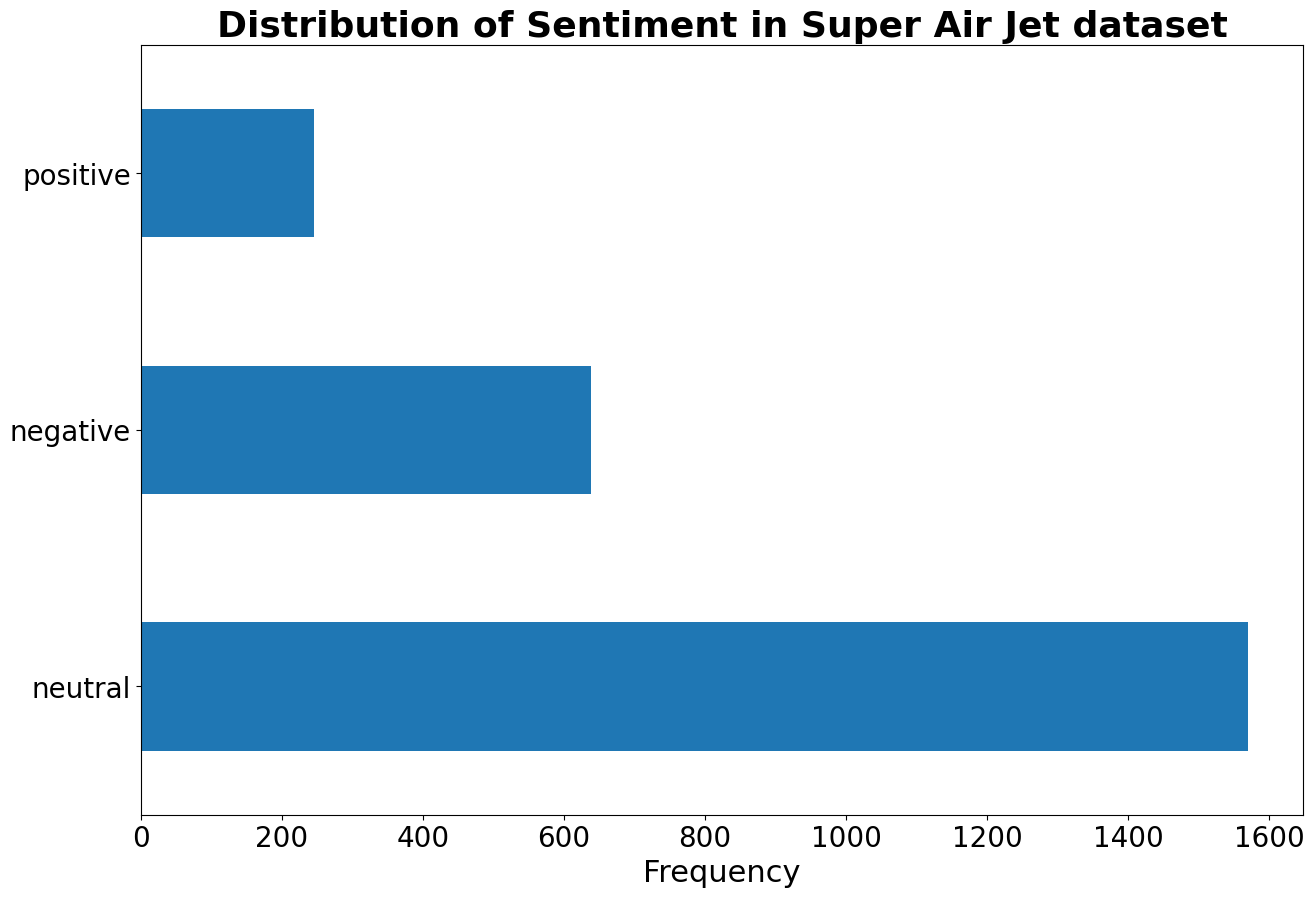

In [ ]:
# Plot sentiment distribution
df_features['Sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of Sentiment in Super Air Jet dataset',
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

In [ ]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []

    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence

    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https':
                filtered_sentence.append(w)
        return filtered_sentence

    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]

    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)

    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)

        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed

In [ ]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df_features, 'content')
df_features['cleaned_text'] = preprocessor.full_preprocess()

<ipython-input-12-1631c16badef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['cleaned_text'] = preprocessor.full_preprocess()


In [ ]:
# Shuffling so we can get random tweets for the test set
seed = 42
df_features = df_features.sample(frac=1, random_state=seed)
# Keep 50 samples of the data as test set
test_set = df_features[:50]

In [ ]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df_features['cleaned_text'][50:],
                                                  df_features['Sentiment'][50:],
                                                  test_size=0.2,
                                                  random_state=seed)

# Get sentiment labels for test set
y_test = test_set['Sentiment']

In [ ]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])

In [ ]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Training size: 1922 tweets
Validation size: 481 tweets
Test size: 50 tweets
Amount of words (columns): 5828 words


In [ ]:
# Multinomial Naive Bayes
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Check results
train_pred = multi_nb.predict(X_train)
val_pred = multi_nb.predict(X_val)
print(f'Accuracy on training set (MultinomialNB): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (MultinomialNB): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (MultinomialNB): 81.9459%
Accuracy on validation set (MultinomialNB): 71.9335%


In [ ]:
# sklearn's Gradient Boosting Classifier (GBM)
gbm = GradientBoostingClassifier(n_estimators=200,
                                 max_depth=6,
                                 random_state=seed)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=200, random_state=42)

In [ ]:
# Check results
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (GBM): 100.0%
Accuracy on validation set (GBM): 78.7942%


In [ ]:
# Hyperparameters that you can tweak
# There are a lot more tweakable hyperparameters that you can find at
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {'objective' : 'multi:softmax',
              'eval_metric' : 'mlogloss',
              'eta' : 0.1,
              'max_depth' : 6,
              'num_class' : 3,
              'lambda' : 0.8,
              'estimators' : 200,
              'seed' : seed

}

# Transform categories into numbers
# negative = 0, neutral = 1 and positive = 2
target_train = y_train.astype('category').cat.codes
target_val = y_val.astype('category').cat.codes

# Transform data into a matrix so that we can use XGBoost
d_train = xgb.DMatrix(X_train, label = target_train)
d_val = xgb.DMatrix(X_val, label = target_val)

# Fit XGBoost
watchlist = [(d_train, 'train'), (d_val, 'validation')]
bst = xgb.train(xgb_params,
                d_train,
                400,
                watchlist,
                early_stopping_rounds = 50,
                verbose_eval = 0)

[09:08:44] WARNING: ../src/learner.cc:767: 
Parameters: { "estimators" } are not used.



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Check results for XGBoost
train_pred = bst.predict(d_train)
val_pred = bst.predict(d_val)
print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (XGBoost): 97.0864%
Accuracy on validation set (XGBoost): 77.7547%


In [ ]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0] // batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        if shuffle:
            np.random.shuffle(sample_index)
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if counter == number_of_batches:
            counter = 0

In [ ]:
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse_output=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [ ]:
# Neural network architecture
initializer = keras.initializers.he_normal(seed=seed)
activation = keras.activations.elu
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-9)

# Build model architecture
model = Sequential()
model.add(Dense(30, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
epochs = 40
batch_size = 24

# Fit the model using the batch_generator
hist = model.fit(x=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                 epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                 steps_per_epoch=X_train.shape[0]//batch_size)

Epoch 1/40
80/80 [==============================] - 1s 4ms/step - loss: 1.0535 - accuracy: 0.5896 - val_loss: 1.0124 - val_accuracy: 0.6154
Epoch 2/40
80/80 [==============================] - 0s 3ms/step - loss: 0.9603 - accuracy: 0.6562 - val_loss: 0.9316 - val_accuracy: 0.6154
Epoch 3/40
80/80 [==============================] - 0s 3ms/step - loss: 0.8597 - accuracy: 0.6698 - val_loss: 0.8639 - val_accuracy: 0.6154
Epoch 4/40
80/80 [==============================] - 0s 3ms/step - loss: 0.8052 - accuracy: 0.6391 - val_loss: 0.8165 - val_accuracy: 0.6154
Epoch 5/40
80/80 [==============================] - 0s 3ms/step - loss: 0.7559 - accuracy: 0.6479 - val_loss: 0.7819 - val_accuracy: 0.6154
Epoch 6/40
80/80 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.6609 - val_loss: 0.7534 - val_accuracy: 0.6154
Epoch 7/40
80/80 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.6682 - val_loss: 0.7277 - val_accuracy: 0.6195
Epoch 8/40
80/80 [==

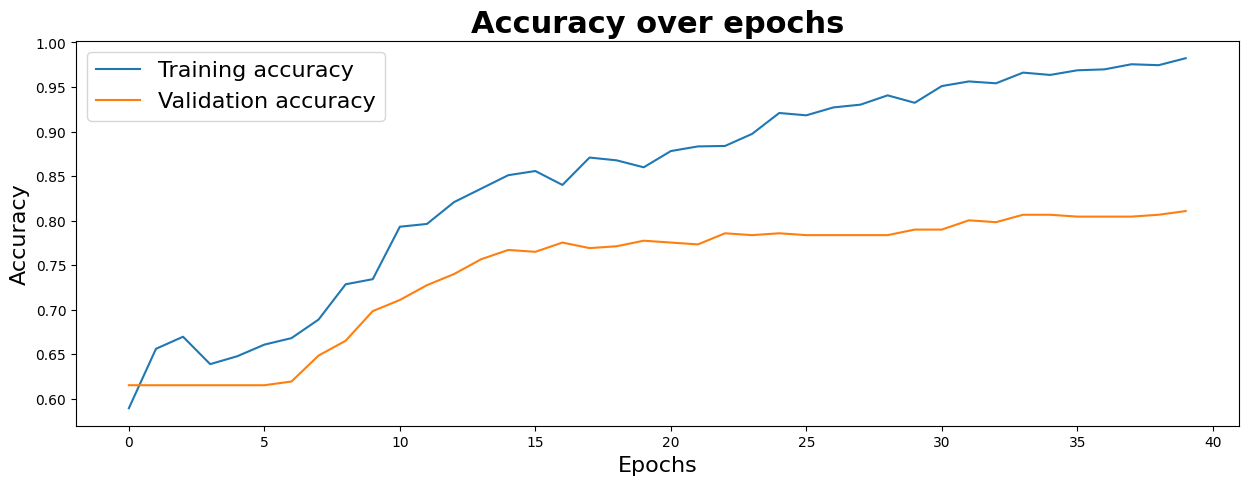

In [ ]:
# Visualize Accuracy
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Get the amount of epochs for visualization
n_epochs = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(15,5))
plt.plot(n_epochs, acc)
plt.plot(n_epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
predictions = text_classifier.predict(X_train)

print(confusion_matrix(y_train,predictions))
print('accuracy score',accuracy_score(y_train, predictions))

[[ 489    0    0]
 [   0 1243    0]
 [   0    0  190]]
accuracy score 1.0


In [ ]:
predictions = text_classifier.predict(X_val)

print(confusion_matrix(y_val,predictions))
print('accuracy score',accuracy_score(y_val, predictions))

[[ 82  49   0]
 [ 15 280   1]
 [ 25  26   3]]
accuracy score 0.7588357588357588


In [ ]:
# Multinomial Naive Bayes
multinb_test_pred = multi_nb.predict(X_test)

# Gradient Boosting Classifier
gbm_test_pred = gbm.predict(X_test)

# XGBoost
# Transform test data for XGBoost
target_test = y_test.astype('category').cat.codes
d_test = xgb.DMatrix(X_test, label = target_test)
xgboost_test_pred = bst.predict(d_test)

# Neural Network predictions
nn_test_pred = [np.argmax(pred) for pred in model.predict(X_test)]

# Random Forest Predictions
RD_test_pred = text_classifier.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [ ]:
# Get accuracies
print(f'Accuracy for Multinomial Naive Bayes: {round(accuracy_score(y_test, multinb_test_pred)*100, 4)}%')
print(f'Accuracy for Gradient Boosting Classifier: {round(accuracy_score(y_test, gbm_test_pred)*100, 4)}%')
print(f'Accuracy for XGBoost: {round(accuracy_score(target_test, xgboost_test_pred)*100, 4)}%')
print(f'Accuracy for Neural Network: {round(accuracy_score(target_test, nn_test_pred)*100, 4)}%')
print(f'Accuracy for Random Forest: {round(accuracy_score(y_test, RD_test_pred)*100, 4)}%')

Accuracy for Multinomial Naive Bayes: 76.0%
Accuracy for Gradient Boosting Classifier: 72.0%
Accuracy for XGBoost: 76.0%
Accuracy for Neural Network: 84.0%
Accuracy for Random Forest: 76.0%


In [ ]:
# Save Neural Network model
model.save('model.h5')